In [17]:
import os, subprocess
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tempfile
tmpdir=tempfile.gettempdir()
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm

#from profile_surface import surface_smoothing

In [18]:
def surface_smoothing(values, surf_filename, fwhm=2):
    """smooth surface values using depth_potential. Will loop over multiple values if necessary
    smooths across surf_filename with fwhm set"""
    #check dimensions
    shrink=False
    flipped=False
    if np.ndim(values)==1:
        values=np.array([values])
        shrink=True
    elif values.shape[0]>values.shape[1]:
        values=values.T
        flipped=True
    new_values=np.zeros_like(values)
    for k,overlay in enumerate(values):
        np.savetxt('/tmp/tmp.txt', overlay, fmt='%.2f')
        print('smoothing surface '+str(k))
        subprocess.call('depth_potential -smooth '+ str(fwhm)+' /tmp/tmp.txt '+ surf_filename + ' /tmp/smtmp.txt',shell=True)
        new_overlay = np.loadtxt('/tmp/smtmp.txt')
        new_values[k] = new_overlay
    if shrink:
        return new_values[0]
    else:
        if flipped==True:
            return new_values.T
        return new_values

In [19]:
def plot_surface(overlay,surface_file,colourmap,min_val,max_val, mask=False,below_thresh=0.01):
    import io_mesh as io
    """ plot surface overlays using ray_trace,
    colourmap is matplotlib colourmap
    surface_file is obj file
    min_val and max_val have to be specified"""
    rand=str(np.random.randint(10000))
    if mask is not False:
        overlay[mask==1]=min_val-below_thresh
    #save two views
    surface=io.load_mesh_geometry(surface_file)
    colours=overlay2colours(overlay,colourmap,min_val,max_val)
    save_coloured_obj(os.path.join(tmpdir,rand+'tmp.obj'),surface['coords'],surface['faces'],colours)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, rand+'tmp.obj ' ) +'-bg white -sup 3 -crop -left -size 1000 1000 -output ' +  os.path.join(tmpdir, rand+'tmp_l.rgb' ),shell=True)
    subprocess.call('ray_trace ' +  os.path.join(tmpdir, rand+'tmp.obj ' ) +'-bg white -sup 3 -crop -right -size 1000 1000 -output ' +  os.path.join(tmpdir, rand+'tmp_r.rgb' ),shell=True)
    imagel=plt.imread( os.path.join(tmpdir, rand+'tmp_l.rgb' ))
    imager=plt.imread( os.path.join(tmpdir, rand+'tmp_r.rgb' ))
    return imagel,imager

def rescale_to_256(array,min_val,max_val):
    """ensure all values lie in range 0 - 255"""
    scaled=(array-min_val)/(max_val-min_val)
    #clip
    array_s=np.round(255*scaled).astype(int)
    return array_s

def rgb_matrix(cmap_name):
    colourmap=cm.get_cmap(cmap_name)
    c=np.zeros((256,4))
    for r in range(256):
        c[r]=list(colourmap(r))
    return c

def save_coloured_obj(surf_mesh,coords,faces,colours):
    """save obj file with coloured vertices
    surfmesh - filename obj
    coords - coordinates
    faces - triangle indices
    colours - n_vert x 4 matrix of colours rgb"""
#write out MNI - obj format
    n_vert=len(coords)
    norms=normal_vectors(coords,faces).tolist()
    XYZ=coords.tolist()
    Tri=faces.tolist()
    with open(surf_mesh,'w') as s:
        line1="P 0.3 0.3 0.4 10 1 " + str(n_vert) + "\n"
        s.write(line1)
        k=-1
        #save coordinates
        for a in XYZ:
            k+=1
            cor=' ' + ' '.join(list(map(str, XYZ[k])))
            s.write('%s\n' % cor)
        s.write('\n')
        #save normals
        for k,a in enumerate(XYZ):
            normal=' ' + ' '.join(list(map(str, norms[k])))
            s.write('%s\n' % normal)
        s.write('\n')
        l=' ' + str(len(Tri))+'\n'
        s.write(l)
        #2 indicates colours are done per vertex
        s.write(' 2\n')
        for colour in colours:
            col=' ' + ' '.join(list(map(str, colour)))
            s.write('%s\n' % col)
        s.write('\n')
        nt=len(Tri)*3
        Triangles=np.arange(3,nt+1,3)
        Rounded8=np.shape(Triangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=Triangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=Triangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        s.write('\n')
        ListOfTriangles=np.array(Tri).flatten()
        Rounded8=np.shape(ListOfTriangles)[0]/8
        N8=int(8*Rounded8)
        Triangles8=ListOfTriangles[0:N8]
        ListTri8=ListOfTriangles[0:N8]
        RowsOf8=np.split(Triangles8,N8/8)
        for r in RowsOf8:
            L=r.tolist()
            Lint=map(int,L)
            Line=' ' + ' '.join(map(str, Lint))
            s.write('%s\n' % Line)
        L=ListOfTriangles[N8:].tolist()
        Lint=map(int,L)
        Line=' ' + ' '.join(map(str, Lint))
        s.write('%s\n' % Line)
        
        
def normal_vectors(vertices,faces):
    norm = np.zeros( vertices.shape, dtype=vertices.dtype )
    tris = vertices[faces]
    n = np.cross( tris[::,1 ] - tris[::,0]  , tris[::,2 ] - tris[::,0] )
    n=normalize_v3(n)
    norm[ faces[:,0] ] += n
    norm[ faces[:,1] ] += n
    norm[ faces[:,2] ] += n
    return normalize_v3(norm)


def normalize_v3(arr):
    ''' Normalize a numpy array of 3 component vectors shape=(n,3) '''
    lens = np.sqrt( arr[:,0]**2 + arr[:,1]**2 + arr[:,2]**2 )
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens                
    return arr

def overlay2colours(overlay,colourmap, min_val, max_val):
    """colour each vertex in an overlay
    below min_val is set to white (0,0,0,0). Above is clipped to max_val"""
    overlay_s=rescale_to_256(overlay,min_val,max_val)
    colours = rgb_matrix(colourmap)
    overlay_rgb=np.zeros((len(overlay),4))
    #set below thresh colours to white
    overlay_rgb[overlay_s<0]=np.array([1,1,1,1])
    overlay_s=np.clip(overlay_s, None, 255).astype(int)
    overlay_rgb[overlay_s>=0]=colours[overlay_s[overlay_s>=0]]
    return overlay_rgb


In [22]:
hemi='right'
overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidence'+hemi+'_20.txt')[:163842]
surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')

In [5]:
overlay=np.nanmean(overlay,axis=1)
overlay=surface_smoothing(overlay, surface_file,3)

smoothing surface 0


In [6]:
mu=np.mean(overlay[mask!=1])
sigma=np.std(overlay[mask!=1])
min_val=0.5#np.min(overlay[mask!=1])
max_val=0.8#np.max(overlay[mask!=1])


In [7]:

l,r = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)



/home/users/kwagstyl/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/users/kwagstyl/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [8]:
bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)


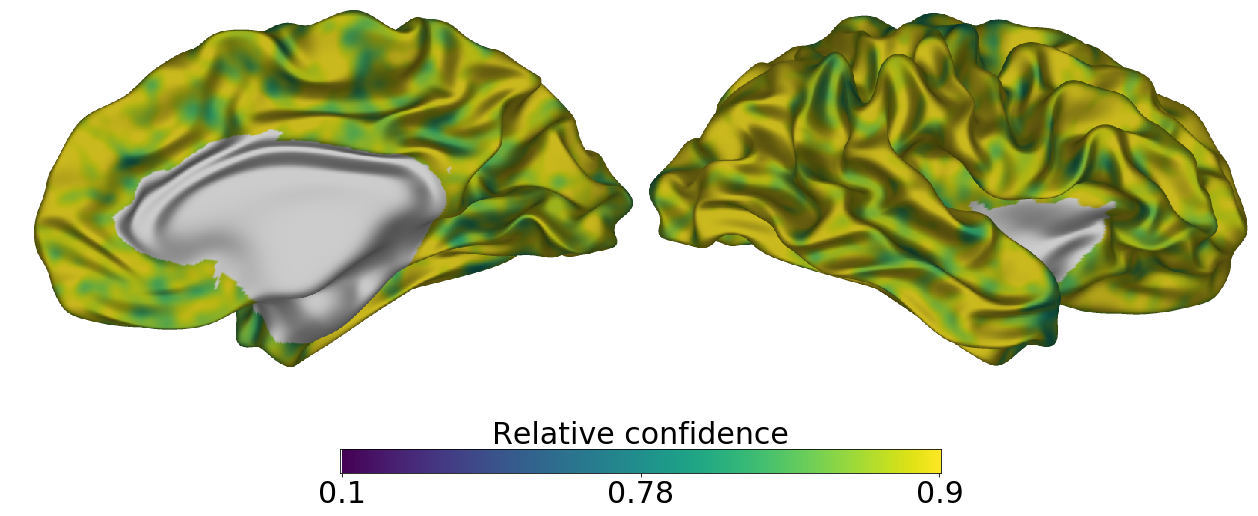

In [21]:
ncol=4
nrow=2
fig = plt.figure(figsize=(25, 10)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), height_ratios=[1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)

ax= plt.subplot(gs[0,0:2])
ax.imshow(l)
ax.axis('off')
ax= plt.subplot(gs[0,2:4])

ax.imshow(r)
ax.axis('off')
ax= plt.subplot(gs[1,1:3])
ax.imshow(np.rot90(bar))
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([0,128,256])
ax.set_xticklabels([np.round(min_val,decimals=2),np.round(mu,decimals=2),np.round(max_val,decimals=2)],size=30)
ax.set_title('Relative confidence', size=30)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/overall_confidence_'+hemi+'.pdf',bbox_inches='tight')

In [10]:
import io_mesh as io
surf = io.load_mesh_geometry('/data1/users/kwagstyl/bigbrain/surfaces/gray_left_327680.obj')
mask=mask.astype(bool)
plt.scatter(surf['coords'][:,1][~mask],overlay[~mask])

KeyboardInterrupt: 

In [ ]:
import glob
basedir='/data1/users/kwagstyl/bigbrain/NeuralNetworks/TrainingData/'
directories=['','V1','new_sections_03-18']
sections=[]
for directory in directories:
    sections.extend(glob.glob(os.path.join(basedir,directory,'Slice*')))

section_lines=np.zeros(6400)


for section in sections:
    section_coord=int(section[-4:])
    with open(os.path.join(section,'white_coordinates.txt')) as f:
        for i, l in enumerate(f):
            pass
    lines=i + 1
    section_lines[section_coord]+=lines

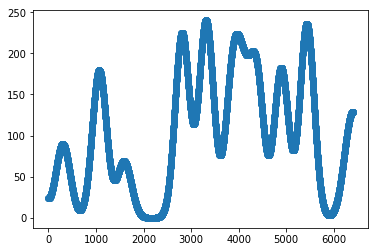

In [67]:
from scipy import ndimage

smoothed=ndimage.filters.gaussian_filter1d(section_lines,150)
plt.scatter(range(6400),smoothed)

0 0
smoothing surface 0
4 0
smoothing surface 0
8 0
smoothing surface 0
12 0
smoothing surface 0
0 3
smoothing surface 0
4 3
smoothing surface 0
8 3
smoothing surface 0
12 3
smoothing surface 0
0 0
smoothing surface 0
4 0
smoothing surface 0
8 0
smoothing surface 0
12 0
smoothing surface 0
0 3
smoothing surface 0
4 3
smoothing surface 0
8 3
smoothing surface 0
12 3
smoothing surface 0


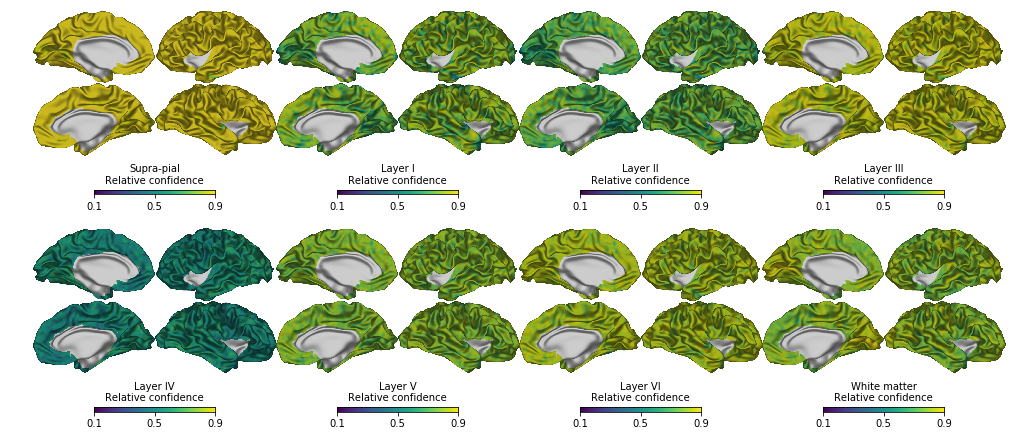

In [24]:
ncol=16
nrow=6
fig = plt.figure(figsize=(20, 8)) 
gs = gridspec.GridSpec(nrow, ncol,  #height_ratios=[10,1,10,1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)
gs.update(wspace=0, hspace=0)

bar=np.reshape(rgb_matrix('viridis'),(256,1,4))
bar=np.vstack(([[[1,1,1,1]]],bar))
bar=np.repeat(bar,10,axis=1)

hemis=['left','right']
titles=[
    'Supra-pial',
    'Layer I',
    'Layer II',
    'Layer III',
    'Layer IV',
    'Layer V',
    'Layer VI',
    'White matter'
]
for k,hemi in enumerate(hemis):
    all_overlay=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidence'+hemi+'_20.txt')[:163842]
    mask=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/archi_'+hemi+'.txt')
    surface_file='/data1/users/kwagstyl/bigbrain/May_2016/flatwhite_'+hemi+'_327680.obj'
    for layer in range(8):
        c=4*(layer%4)
        ro=3*(layer//4)
        print(c,ro)
        overlay=np.nan_to_num(all_overlay[:,layer])
        overlay=surface_smoothing(overlay, surface_file,3)
        #mu=np.mean(overlay[mask!=1])
        #sigma=np.std(overlay[mask!=1])
        min_val=0.1 #np.min(overlay[mask!=1])
        max_val=0.9 #np.max(overlay[mask!=1])
        surface_plots = plot_surface(overlay, surface_file,'viridis',mask=mask, min_val=min_val, max_val=max_val)
        ax= plt.subplot(gs[ro+k,c:c+2])
        ax.imshow(surface_plots[np.abs(k-1)])
        ax.axis('off')
        ax= plt.subplot(gs[ro+k,c+2:c+4])
        ax.imshow(surface_plots[1-np.abs(k-1)])
        ax.axis('off')
        if k ==0:
            ax= plt.subplot(gs[ro+2,c+1:c+3])
            ax.imshow(np.rot90(bar))
        #ax.axis('off')
            ax.set_yticks([])
            ax.set_xticks([0,128,256])
            ax.set_xticklabels([np.round(min_val,decimals=1),0.5,np.round(max_val,decimals=1)] ,size=10)
            ax.set_title(titles[layer]+'\nRelative confidence', size=10)
   

        
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/layer_confidence.pdf',bbox_inches='tight')


In [ ]:
overlays=np.loadtxt('/data1/users/kwagstyl/bigbrain/NeuralNetworks/confidence/confidenceleft_20.txt').T
surface_file='/data1/users/kwagstyl/bigbrain/NeuralNetworks/surfdir/tmp_2.0_white_left_up_iso.obj'
mask=np.zeros(len(overlays.T))

In [ ]:
ncol=16
nrow=4
fig = plt.figure(figsize=(25, 10)) 
gs = gridspec.GridSpec(nrow, ncol, width_ratios=np.ones(ncol), height_ratios=[1,0.1,1,0.1],
         wspace=0.05, hspace=0, left=0.17, right=0.845)
#gs.tight_layout(fig)

overlays=np.nan_to_num(overlays)

for layer in range(8):
    c=4*(layer%4)
    ro=2*(layer//4)
    print(c,ro)
    overlay=overlays[layer]
    mu=np.mean(overlay[mask!=1])
    sigma=np.std(overlay[mask!=1])
    min_val=0 #mu-3*sigma
    max_val=1 #mu+3*sigma
    l,r, bar = plot_surface(overlay, surface_file,mask=mask, min_val=min_val, max_val=max_val)
    ax= plt.subplot(gs[ro,c:c+2])
    ax.imshow(l)
    ax.axis('off')
    ax= plt.subplot(gs[ro,c+2:c+4])

    ax.imshow(r)
    ax.axis('off')
    ax= plt.subplot(gs[ro+1,c+1:c+3])
    ax.imshow(np.rot90(bar[::-1]))
    #ax.axis('off')
    ax.set_yticks([])
    ax.set_xticks([0,149,299])
    ax.set_xticklabels([np.round(min_val,decimals=2),np.round(mu,decimals=2),np.round(max_val,decimals=2)] ,size=3)
    ax.set_title('Cortical thickness (mm)', size=3)
fig.savefig('/data1/users/kwagstyl/bigbrain/NeuralNetworks/figs/confidences.pdf')


In [31]:
l=overlays[5]

In [39]:
bar[::-1]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        ...,
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098],
        [0.02352941, 0.        , 0.02745098]],

       [[0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        ...,
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196],
        [0.05098039, 0.        , 0.05490196]],

       ...,

       [[0.6392157 , 0.5529412 , 0.5529412 ],
        [0.6392157 , 0.5529412 , 0.5529412 ],
        [0.6392157 , 0

In [4]:
print('ray_trace ' +  os.path.join(tmpdir, 'tmp.obj ' ) +'-bg white -sup 3 -crop -left -size 1000 1000 -output ' +  os.path.join(tmpdir, 'tmp_l.rgb' ))

ray_trace /tmp/tmp.obj -bg white -sup 3 -crop -left -size 1000 1000 -output /tmp/tmp_l.rgb


In [8]:
print('colour_object ' + surface_file + ' ' + os.path.join(tmpdir,'tmp.txt ') + os.path.join(tmpdir, 'tmp.obj ' )
                   + 'spectral ' + str(min(overlay)) + ' '+ str(max(overlay)))

colour_object /data1/users/kwagstyl/bigbrain/May_2016/flatwhite_left_327680.obj /tmp/tmp.txt /tmp/tmp.obj spectral 0.0 3.83639
